Note: you may need to restart the kernel to use updated packages.


C:\Users\saina\AppData\Local\Temp\ipykernel_21092\1300495359.py:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)
C:\Users\saina\AppData\Local\Temp\ipykernel_21092\1300495359.py:49: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[['demand_lag_1', 'demand_lag_7', 'rrp_lag_1', 'rrp_lag_7']].fillna(method='bfill', inplace=True)
C:\Users\saina\AppData\Local\Temp\ipykernel_21092\1300495359.py:49:

NaN count before dropping:
demand                   0
demand_lag_1             0
demand_lag_7             0
rrp                      0
rrp_lag_1                0
rrp_lag_7                0
min_temperature          0
max_temperature          0
solar_exposure           0
rainfall                 0
temp_rain_interaction    0
dtype: int64


18:08:23 - cmdstanpy - INFO - Chain [1] start processing
18:08:23 - cmdstanpy - INFO - Chain [1] done processing
18:08:24 - cmdstanpy - INFO - Chain [1] start processing
18:08:24 - cmdstanpy - INFO - Chain [1] done processing


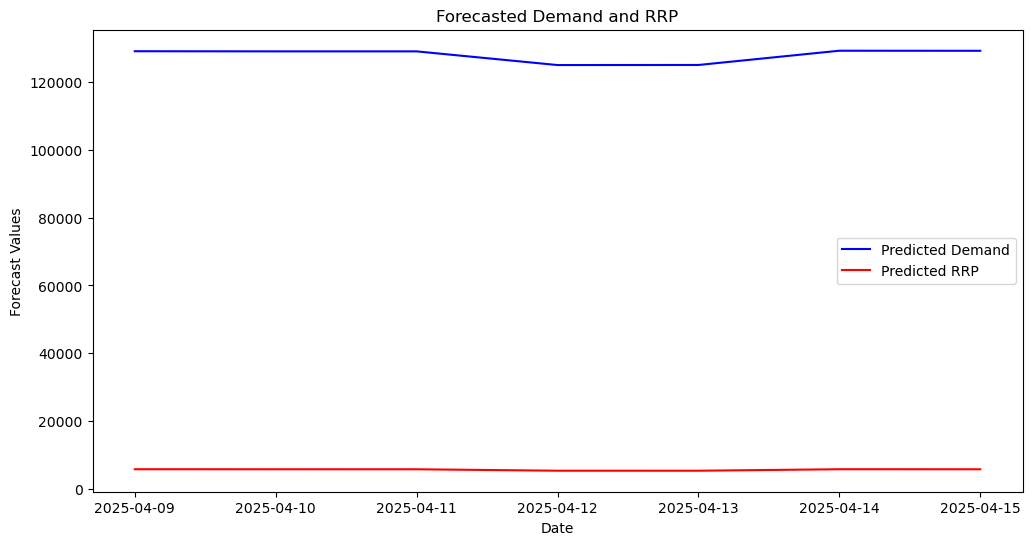

Demand Forecast:
          ds           yhat
0 2025-04-09  129066.300662
1 2025-04-10  129025.235410
2 2025-04-11  129024.238926
3 2025-04-12  124990.485015
4 2025-04-13  125012.954360
5 2025-04-14  129216.669240
6 2025-04-15  129195.392766

RRP Forecast:
          ds         yhat
0 2025-04-09  5785.469259
1 2025-04-10  5776.883395
2 2025-04-11  5772.667490
3 2025-04-12  5350.933991
4 2025-04-13  5347.216718
5 2025-04-14  5785.653687
6 2025-04-15  5775.865546


In [1]:
%pip install prophet numpy pandas scikit-learn matplotlib
import pandas as pd
from sklearn.preprocessing import StandardScaler
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle

# Load dataset
df = pd.read_csv('./cleaned_dataset _3.csv')

# Ensure date column is present and valid
if 'date' not in df.columns or df['date'].isna().all():
    print("🚨 Date column is missing! Reconstructing...")
    df['date'] = pd.date_range(start='2020-01-01', periods=len(df), freq='D')
else:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Create lag features for demand and rrp
df['demand_lag_1'] = df['demand'].shift(1)
df['demand_lag_7'] = df['demand'].shift(7)
df['rrp_lag_1'] = df['rrp'].shift(1)
df['rrp_lag_7'] = df['rrp'].shift(7)

# Create interaction term for weather effects
df['temp_rain_interaction'] = df['min_temperature'] * df['rainfall']

df['weekday'] = df['date'].dt.weekday
df['is_weekend'] = (df['weekday'] >= 5).astype(int)
df['extreme_weather'] = ((df['max_temperature'] > df['max_temperature'].quantile(0.95)) | 
                         (df['rainfall'] > df['rainfall'].quantile(0.95))).astype(int)

df['ds'] = df['date'].copy()
df = df.dropna(subset=['ds'])

# Scaling
scaler = StandardScaler()
features_to_scale = ['demand', 'demand_lag_1', 'demand_lag_7', 'rrp', 'rrp_lag_1', 'rrp_lag_7',
                     'min_temperature', 'max_temperature', 'solar_exposure',
                     'rainfall', 'temp_rain_interaction']

# Fill missing values using column mean before rolling mean
for col in features_to_scale:
    df[col].fillna(df[col].mean(), inplace=True)
    df[col] = df[col].rolling(window=7, min_periods=1).mean()

# Handle lags properly
df[['demand_lag_1', 'demand_lag_7', 'rrp_lag_1', 'rrp_lag_7']].fillna(method='bfill', inplace=True)

# Forward and backward fill any remaining NaNs
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

# Debug: Check for NaNs before dropping rows
nan_report = df[features_to_scale].isna().sum()
print("NaN count before dropping:")
print(nan_report)

if nan_report.sum() > 0:
    print(f"🚨 Remaining NaNs (after all filling attempts):\n{nan_report}")

df = df.dropna(subset=features_to_scale)
if df.empty:
    raise ValueError("🚨 All rows have NaNs after preprocessing! Check data integrity.")

# Scale features
scaled_features = scaler.fit_transform(df[features_to_scale])
scaled_df = pd.DataFrame(scaled_features, columns=features_to_scale)
scaled_df['is_weekend'] = df['is_weekend'].values
scaled_df['extreme_weather'] = df['extreme_weather'].values
scaled_df['ds'] = df['ds'].values
scaled_df['y_demand'] = df['demand'].values
scaled_df['y_rrp'] = df['rrp'].values
scaled_df = scaled_df.dropna(subset=['y_demand', 'y_rrp'])
scaled_df['ds'] = pd.to_datetime(scaled_df['ds'])

# Split Data
new_scaler = StandardScaler()
train_df_raw = df.iloc[:int(len(df) * 0.8)].copy()
test_df_raw = df.iloc[int(len(df) * 0.8):].copy()

train_features = new_scaler.fit_transform(train_df_raw[features_to_scale])
train_df = pd.DataFrame(train_features, columns=features_to_scale, index=train_df_raw.index)
train_df['is_weekend'] = train_df_raw['is_weekend'].values
train_df['extreme_weather'] = train_df_raw['extreme_weather'].values
train_df['ds'] = pd.to_datetime(train_df_raw['ds'].values)
train_df['y_demand'] = train_df_raw['demand'].values
train_df['y_rrp'] = train_df_raw['rrp'].values

test_features = new_scaler.transform(test_df_raw[features_to_scale])
test_df = pd.DataFrame(test_features, columns=features_to_scale, index=test_df_raw.index)
test_df['is_weekend'] = test_df_raw['is_weekend'].values
test_df['extreme_weather'] = test_df_raw['extreme_weather'].values
test_df['ds'] = pd.to_datetime(test_df_raw['ds'].values)
test_df['y_demand'] = test_df_raw['demand'].values
test_df['y_rrp'] = test_df_raw['rrp'].values

# Train Prophet Models
model_demand = Prophet()
model_rrp = Prophet()
regressor_cols = ['demand_lag_1', 'demand_lag_7', 'rrp_lag_1', 'rrp_lag_7',
                  'min_temperature', 'max_temperature', 'solar_exposure',
                  'rainfall', 'temp_rain_interaction', 'is_weekend', 'extreme_weather']

for col in regressor_cols:
    model_demand.add_regressor(col)
    model_rrp.add_regressor(col)

train_df_demand = train_df[['ds', 'y_demand'] + regressor_cols].rename(columns={'y_demand': 'y'})
train_df_rrp = train_df[['ds', 'y_rrp'] + regressor_cols].rename(columns={'y_rrp': 'y'})

model_demand.fit(train_df_demand)
model_rrp.fit(train_df_rrp)

# Future Prediction
start_date = input("Enter forecast start date (YYYY-MM-DD): ")
num_days = int(input("Enter number of days to forecast: "))
future_dates = pd.date_range(start=start_date, periods=num_days, freq='D')
future = pd.DataFrame({'ds': future_dates})

# Compute regressors dynamically using last known values
for col in regressor_cols:
    future[col] = train_df[col].iloc[-1]

forecast_demand = model_demand.predict(future)
forecast_rrp = model_rrp.predict(future)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(forecast_demand['ds'], forecast_demand['yhat'], label='Predicted Demand', color='blue')
plt.plot(forecast_rrp['ds'], forecast_rrp['yhat'], label='Predicted RRP', color='red')
plt.xlabel('Date')
plt.ylabel('Forecast Values')
plt.title('Forecasted Demand and RRP')
plt.legend()
plt.show()

print("Demand Forecast:")
print(forecast_demand[['ds', 'yhat']])
print("\nRRP Forecast:")
print(forecast_rrp[['ds', 'yhat']])


In [3]:
# Create future dates DataFrame as before.
future_dates = pd.date_range(start=start_date, periods=num_days, freq='D')
future = pd.DataFrame({'ds': future_dates})

# For features such as is_weekend, compute them from ds.
future['is_weekend'] = (future['ds'].dt.weekday >= 5).astype(int)

# Compute day-of-year for seasonal features.
future['day_of_year'] = future['ds'].dt.dayofyear

# For weather features, compute historical daily averages (using train_df or df)
weather_features = ['min_temperature', 'max_temperature', 'solar_exposure', 'rainfall']
weather_avg = train_df.copy()
weather_avg['day_of_year'] = weather_avg['ds'].dt.dayofyear
weather_avg = weather_avg.groupby('day_of_year')[weather_features].mean().reset_index()

# Merge the seasonal weather averages onto future.
future = future.merge(weather_avg, on='day_of_year', how='left')

# Recompute the interaction term for weather.
future['temp_rain_interaction'] = future['min_temperature'] * future['rainfall']

# For lag features and rrp regressors, use the overall training mean.
lag_regressors = ['demand_lag_1', 'demand_lag_7', 'rrp_lag_1', 'rrp_lag_7']
for col in lag_regressors:
    future[col] = train_df[col].mean()

# For extreme weather, use the quantile thresholds computed from your dataset.
q_max_temp = df['max_temperature'].quantile(0.95)
q_rainfall = df['rainfall'].quantile(0.95)
future['extreme_weather'] = ((future['max_temperature'] > q_max_temp) | (future['rainfall'] > q_rainfall)).astype(int)

# Ensure that all regressors are present in the right order.
for col in regressor_cols:
    if col not in future.columns:
        # For any regressors not computed above, fill with training average
        future[col] = train_df[col].mean()

# Optionally drop the extra column used for merging.
future.drop(columns='day_of_year', inplace=True)

# Now forecast using the modified future DataFrame.
forecast_demand = model_demand.predict(future)
forecast_rrp = model_rrp.predict(future)

# Display predictions.
print("Demand Forecast:")
print(forecast_demand[['ds', 'yhat']])
print("\nRRP Forecast:")
print(forecast_rrp[['ds', 'yhat']])


Demand Forecast:
          ds           yhat
0 2025-04-09  119100.896073
1 2025-04-10  119213.298181
2 2025-04-11  119295.677415
3 2025-04-12  119034.650761
4 2025-04-13  119050.702160
5 2025-04-14  119344.657550
6 2025-04-15  119292.158672

RRP Forecast:
          ds         yhat
0 2025-04-09  4018.874886
1 2025-04-10  4035.831365
2 2025-04-11  4045.060132
3 2025-04-12  4034.921493
4 2025-04-13  4032.954606
5 2025-04-14  4046.048782
6 2025-04-15  4034.483722
